In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import warnings

# Suppress warnings that might appear when processing signals
warnings.filterwarnings('ignore')

# Constants
SAMPLE_RATE = 1000  # Hz (1 ms sampling)
WINDOW_SIZE = 1000  # 1 second windows
HOP_LENGTH = 500    # 50% overlap
NUM_CLASSES = 3     # footsteps, silence, vehicle
CLASS_NAMES = ['Footsteps', 'Silence', 'Vehicle']

# Set PyTorch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: Load data
def load_data(footsteps_path, silence_path, vehicle_path):
    try:
        footsteps_data = pd.read_csv(footsteps_path, header=None).values.flatten()
        silence_data = pd.read_csv(silence_path, header=None).values.flatten()
        vehicle_data = pd.read_csv(vehicle_path, header=None).values.flatten()
        
        # Ensure data is finite (no NaN or Inf values)
        footsteps_data = np.nan_to_num(footsteps_data, nan=0.0, posinf=0.0, neginf=0.0)
        silence_data = np.nan_to_num(silence_data, nan=0.0, posinf=0.0, neginf=0.0)
        vehicle_data = np.nan_to_num(vehicle_data, nan=0.0, posinf=0.0, neginf=0.0)
        
        print(f"Footsteps: {len(footsteps_data)} samples")
        print(f"Silence: {len(silence_data)} samples")
        print(f"Vehicle: {len(vehicle_data)} samples")
        
        return footsteps_data, silence_data, vehicle_data
    
    except Exception as e:
        print(f"Error loading files: {e}")
        print("Creating synthetic data for testing...")
        
        # Generate synthetic data for testing
        t_footsteps = np.linspace(0, 34, 34 * SAMPLE_RATE)
        footsteps_data = np.sin(2 * np.pi * 2 * t_footsteps) * (np.random.normal(0, 0.1, len(t_footsteps)) + 
                          0.5 * (np.sin(2 * np.pi * 0.5 * t_footsteps) > 0.7))
        
        t_silence = np.linspace(0, 26, 26 * SAMPLE_RATE)
        silence_data = np.random.normal(0, 0.05, len(t_silence))
        
        t_vehicle = np.linspace(0, 17, 17 * SAMPLE_RATE)
        vehicle_data = np.sin(2 * np.pi * 0.2 * t_vehicle) + np.random.normal(0, 0.2, len(t_vehicle))
        
        return footsteps_data, silence_data, vehicle_data


Using device: cuda:0


In [5]:

# Step 2: Segment signals and visualize
def segment_signal(signal, window_size=WINDOW_SIZE, hop_length=HOP_LENGTH):
    segments = []
    for i in range(0, len(signal) - window_size, hop_length):
        segment = signal[i:i + window_size]
        # Ensure segment is finite
        segment = np.nan_to_num(segment, nan=0.0, posinf=0.0, neginf=0.0)
        segments.append(segment)
    return np.array(segments)

def visualize_signals(footsteps_data, silence_data, vehicle_data, n_samples=1000):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(footsteps_data[:n_samples])
    plt.title('Footsteps Signal (First 1000 samples)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    
    plt.subplot(3, 1, 2)
    plt.plot(silence_data[:n_samples])
    plt.title('Silence/Background Signal (First 1000 samples)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    
    plt.subplot(3, 1, 3)
    plt.plot(vehicle_data[:n_samples])
    plt.title('Vehicle Signal (First 1000 samples)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.savefig('signal_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import warnings

# Suppress warnings that might appear when processing signals
warnings.filterwarnings('ignore')

# Constants
SAMPLE_RATE = 1000  # Hz (1 ms sampling)
WINDOW_SIZE = 1000  # 1 second windows
HOP_LENGTH = 500    # 50% overlap
NUM_CLASSES = 3     # footsteps, silence, vehicle
CLASS_NAMES = ['Footsteps', 'Silence', 'Vehicle']

# Set PyTorch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Step 1: Load data
def load_data(footsteps_path, silence_path, vehicle_path):
    try:
        footsteps_data = pd.read_csv(footsteps_path, header=None).values.flatten()
        silence_data = pd.read_csv(silence_path, header=None).values.flatten()
        vehicle_data = pd.read_csv(vehicle_path, header=None).values.flatten()
        
        # Ensure data is finite (no NaN or Inf values)
        footsteps_data = np.nan_to_num(footsteps_data, nan=0.0, posinf=0.0, neginf=0.0)
        silence_data = np.nan_to_num(silence_data, nan=0.0, posinf=0.0, neginf=0.0)
        vehicle_data = np.nan_to_num(vehicle_data, nan=0.0, posinf=0.0, neginf=0.0)
        
        print(f"Footsteps: {len(footsteps_data)} samples")
        print(f"Silence: {len(silence_data)} samples")
        print(f"Vehicle: {len(vehicle_data)} samples")
        
        return footsteps_data, silence_data, vehicle_data
    
    except Exception as e:
        print(f"Error loading files: {e}")
        print("Creating synthetic data for testing...")
        
        # Generate synthetic data for testing
        t_footsteps = np.linspace(0, 34, 34 * SAMPLE_RATE)
        footsteps_data = np.sin(2 * np.pi * 2 * t_footsteps) * (np.random.normal(0, 0.1, len(t_footsteps)) + 
                          0.5 * (np.sin(2 * np.pi * 0.5 * t_footsteps) > 0.7))
        
        t_silence = np.linspace(0, 26, 26 * SAMPLE_RATE)
        silence_data = np.random.normal(0, 0.05, len(t_silence))
        
        t_vehicle = np.linspace(0, 17, 17 * SAMPLE_RATE)
        vehicle_data = np.sin(2 * np.pi * 0.2 * t_vehicle) + np.random.normal(0, 0.2, len(t_vehicle))
        
        return footsteps_data, silence_data, vehicle_data

# Step 2: Segment signals and visualize
def segment_signal(signal, window_size=WINDOW_SIZE, hop_length=HOP_LENGTH):
    segments = []
    for i in range(0, len(signal) - window_size, hop_length):
        segment = signal[i:i + window_size]
        # Ensure segment is finite
        segment = np.nan_to_num(segment, nan=0.0, posinf=0.0, neginf=0.0)
        segments.append(segment)
    return np.array(segments)

def visualize_signals(footsteps_data, silence_data, vehicle_data, n_samples=1000):
    plt.figure(figsize=(15, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(footsteps_data[:n_samples])
    plt.title('Footsteps Signal (First 1000 samples)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    
    plt.subplot(3, 1, 2)
    plt.plot(silence_data[:n_samples])
    plt.title('Silence/Background Signal (First 1000 samples)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    
    plt.subplot(3, 1, 3)
    plt.plot(vehicle_data[:n_samples])
    plt.title('Vehicle Signal (First 1000 samples)')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    
    plt.tight_layout()
    plt.savefig('signal_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

# Step 3: Feature Extraction without relying on librosa MFCC
def extract_time_domain_features(segment):
    """Extract time domain features from a signal segment"""
    features = []
    
    # Ensure the segment is finite
    segment = np.nan_to_num(segment, nan=0.0, posinf=0.0, neginf=0.0)
    
    # RMS energy
    rms = np.sqrt(np.mean(segment**2))
    features.append(rms)
    
    # Zero crossing rate
    zero_crossing_rate = np.sum(np.abs(np.diff(np.sign(segment)))) / (2 * len(segment))
    features.append(zero_crossing_rate)
    
    # Statistical features
    features.append(np.mean(segment))
    features.append(np.std(segment))
    features.append(np.max(np.abs(segment)))
    features.append(np.median(np.abs(segment)))
    
    # Add peak detection
    peaks = np.where((segment[1:-1] > segment[:-2]) & (segment[1:-1] > segment[2:]))[0]
    features.append(len(peaks) / len(segment))  # Peak density
    
    # Add autocorrelation features (useful for periodicity)
    autocorr = np.correlate(segment, segment, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    if len(autocorr) > 1:
        features.append(np.mean(autocorr))
        features.append(np.std(autocorr))
    else:
        features.extend([0, 0])
    
    return np.array(features)

def extract_spectral_features(segment, sr=SAMPLE_RATE):
    """Extract frequency domain features from a signal segment"""
    features = []
    
    # Ensure the segment is finite
    segment = np.nan_to_num(segment, nan=0.0, posinf=0.0, neginf=0.0)
    
    # FFT features
    fft_features = np.abs(np.fft.rfft(segment))
    freqs = np.fft.rfftfreq(len(segment), 1/sr)
    
    # Ensure FFT features are finite
    fft_features = np.nan_to_num(fft_features, nan=0.0, posinf=0.0, neginf=0.0)
    
    # Spectral centroid
    if np.sum(fft_features) > 0:
        spectral_centroid = np.sum(freqs * fft_features) / np.sum(fft_features)
    else:
        spectral_centroid = 0
    features.append(spectral_centroid)
    
    # Spectral bandwidth
    if np.sum(fft_features) > 0:
        spectral_bandwidth = np.sqrt(np.sum(((freqs - spectral_centroid) ** 2) * fft_features) / np.sum(fft_features))
    else:
        spectral_bandwidth = 0
    features.append(spectral_bandwidth)
    
    # Power in different frequency bands
    # Low frequencies (0-10 Hz) - common for vehicles
    low_idx = np.where(freqs <= 10)[0]
    if len(low_idx) > 0 and np.sum(fft_features) > 0:
        low_power = np.sum(fft_features[low_idx]) / np.sum(fft_features)
    else:
        low_power = 0
    features.append(low_power)
    
    # Mid frequencies (10-100 Hz) - common for footsteps
    mid_idx = np.where((freqs > 10) & (freqs <= 100))[0]
    if len(mid_idx) > 0 and np.sum(fft_features) > 0:
        mid_power = np.sum(fft_features[mid_idx]) / np.sum(fft_features)
    else:
        mid_power = 0
    features.append(mid_power)
    
    # High frequencies (100-500 Hz) - common for environmental noise
    high_idx = np.where((freqs > 100) & (freqs <= 500))[0]
    if len(high_idx) > 0 and np.sum(fft_features) > 0:
        high_power = np.sum(fft_features[high_idx]) / np.sum(fft_features)
    else:
        high_power = 0
    features.append(high_power)
    
    # Spectral roll-off
    if np.sum(fft_features) > 0:
        cumsum = np.cumsum(fft_features)
        rolloff_point = np.where(cumsum >= 0.85 * np.sum(fft_features))[0]
        rolloff = freqs[rolloff_point[0]] if len(rolloff_point) > 0 else 0
    else:
        rolloff = 0
    features.append(rolloff)
    
    # Custom FFT-based features instead of MFCC
    # Take several points from the spectrum to characterize it
    if len(fft_features) >= 13:
        # Divide the spectrum into 13 bands (similar to MFCC)
        bands = np.array_split(fft_features, 13)
        band_energies = [np.mean(band) for band in bands]
        features.extend(band_energies)
    else:
        # If spectrum is too small, pad with zeros
        features.extend([0] * 13)
    
    return np.array(features)

def extract_features(segment):
    """Extract both time and frequency domain features"""
    try:
        time_features = extract_time_domain_features(segment)
        spectral_features = extract_spectral_features(segment)
        features = np.concatenate([time_features, spectral_features])
        return features
    except Exception as e:
        print(f"Error in feature extraction: {e}")
        # Return a vector of zeros in case of error
        return np.zeros(28)  # Expected feature vector size based on our implementation

def visualize_spectral_content(footsteps_segments, silence_segments, vehicle_segments):
    """Visualize spectral content for each signal type"""
    plt.figure(figsize=(15, 12))
    
    signals = [
        (footsteps_segments[0], "Footsteps"),
        (silence_segments[0], "Silence/Background"),
        (vehicle_segments[0], "Vehicle")
    ]
    
    for i, (signal, title) in enumerate(signals):
        plt.subplot(3, 2, 2*i+1)
        
        # Time domain signal
        plt.plot(signal)
        plt.title(f'{title} - Time Domain')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        
        plt.subplot(3, 2, 2*i+2)
        
        # Frequency domain using FFT
        signal_fft = np.abs(np.fft.rfft(signal))
        freqs = np.fft.rfftfreq(len(signal), 1/SAMPLE_RATE)
        
        plt.plot(freqs, signal_fft)
        plt.title(f'{title} - Frequency Domain')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.xlim([0, 250])  # Limit to meaningful frequency range
    
    plt.tight_layout()
    plt.savefig('spectral_content.png', dpi=300, bbox_inches='tight')
    plt.show()

def visualize_feature_comparison(footsteps_features, silence_features, vehicle_features):
    """Visualize comparison of key features between signal types"""
    # Select a subset of features to visualize
    feature_names = [
        "RMS Energy", 
        "Zero Crossing Rate", 
        "Spectral Centroid", 
        "Low Freq Power (0-10Hz)", 
        "Mid Freq Power (10-100Hz)",
        "High Freq Power (100-500Hz)"
    ]
    
    # Feature indices (assuming the order from extract_features function)
    feature_indices = [0, 1, 10, 12, 13, 14]
    
    plt.figure(figsize=(15, 10))
    
    for i, (idx, name) in enumerate(zip(feature_indices, feature_names)):
        plt.subplot(3, 2, i+1)
        
        # Create boxplots
        plt.boxplot([
            footsteps_features[:, idx],
            silence_features[:, idx],
            vehicle_features[:, idx]
        ], labels=CLASS_NAMES)
        
        plt.title(f'Feature: {name}')
        plt.ylabel('Value')
    
    plt.tight_layout()
    plt.savefig('feature_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

Using device: cuda:0


In [7]:

# Step 4: PyTorch Models
class SpectralCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SpectralCNN, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            
            nn.Conv1d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )
        
        # Calculate output size of convolutional layers
        conv_output_size = input_size // 8
        if conv_output_size < 1:
            conv_output_size = 1
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * conv_output_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        # Add channel dimension
        x = x.unsqueeze(1)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc_layers(x)
        return x

class SpectralLSTM(nn.Module):
    def __init__(self, input_size, num_classes, hidden_size=64):
        super(SpectralLSTM, self).__init__()
        self.hidden_size = hidden_size
        
        self.lstm1 = nn.LSTM(1, hidden_size, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size*2, hidden_size, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size*2, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
    
    def forward(self, x):
        # Add feature dimension
        x = x.unsqueeze(2)
        
        lstm_out1, _ = self.lstm1(x)
        lstm_out1 = self.dropout1(lstm_out1)
        lstm_out2, _ = self.lstm2(lstm_out1)
        lstm_out2 = self.dropout2(lstm_out2)
        
        # Take the final output
        lstm_out = lstm_out2[:, -1, :]
        
        x = self.fc(lstm_out)
        return x


Footsteps: 1258037 samples
Silence: 1013961 samples
Vehicle: 203976 samples


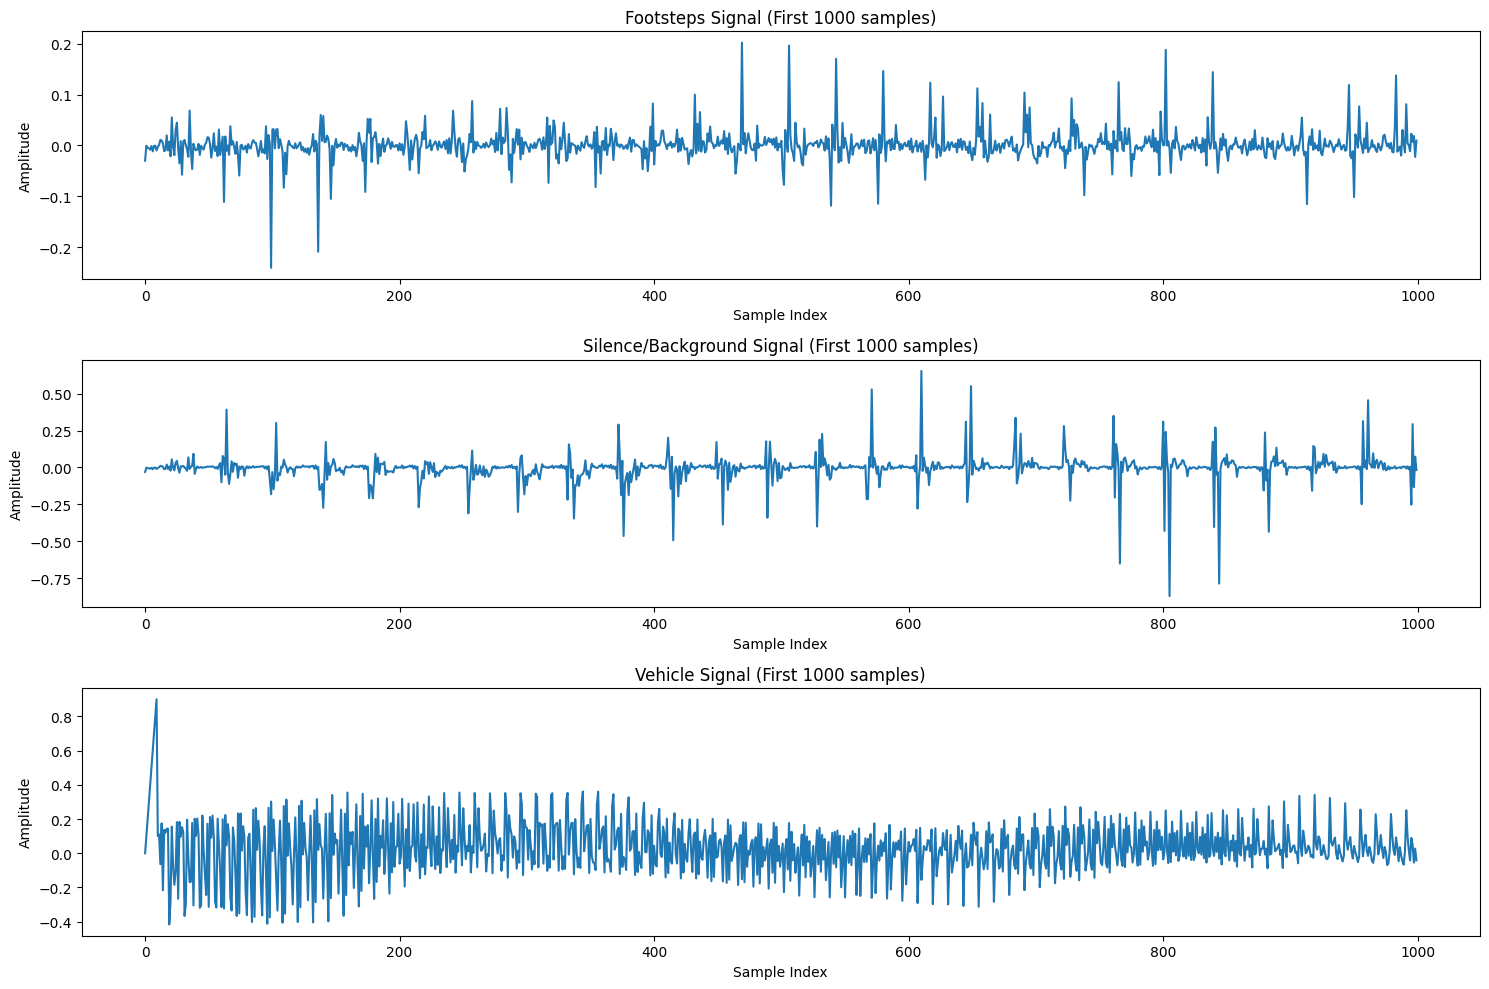

Segmenting signals with window size: 1000 and hop length: 500
Footsteps segments: 2515
Silence segments: 2026
Vehicle segments: 406
Generating spectral content visualizations...


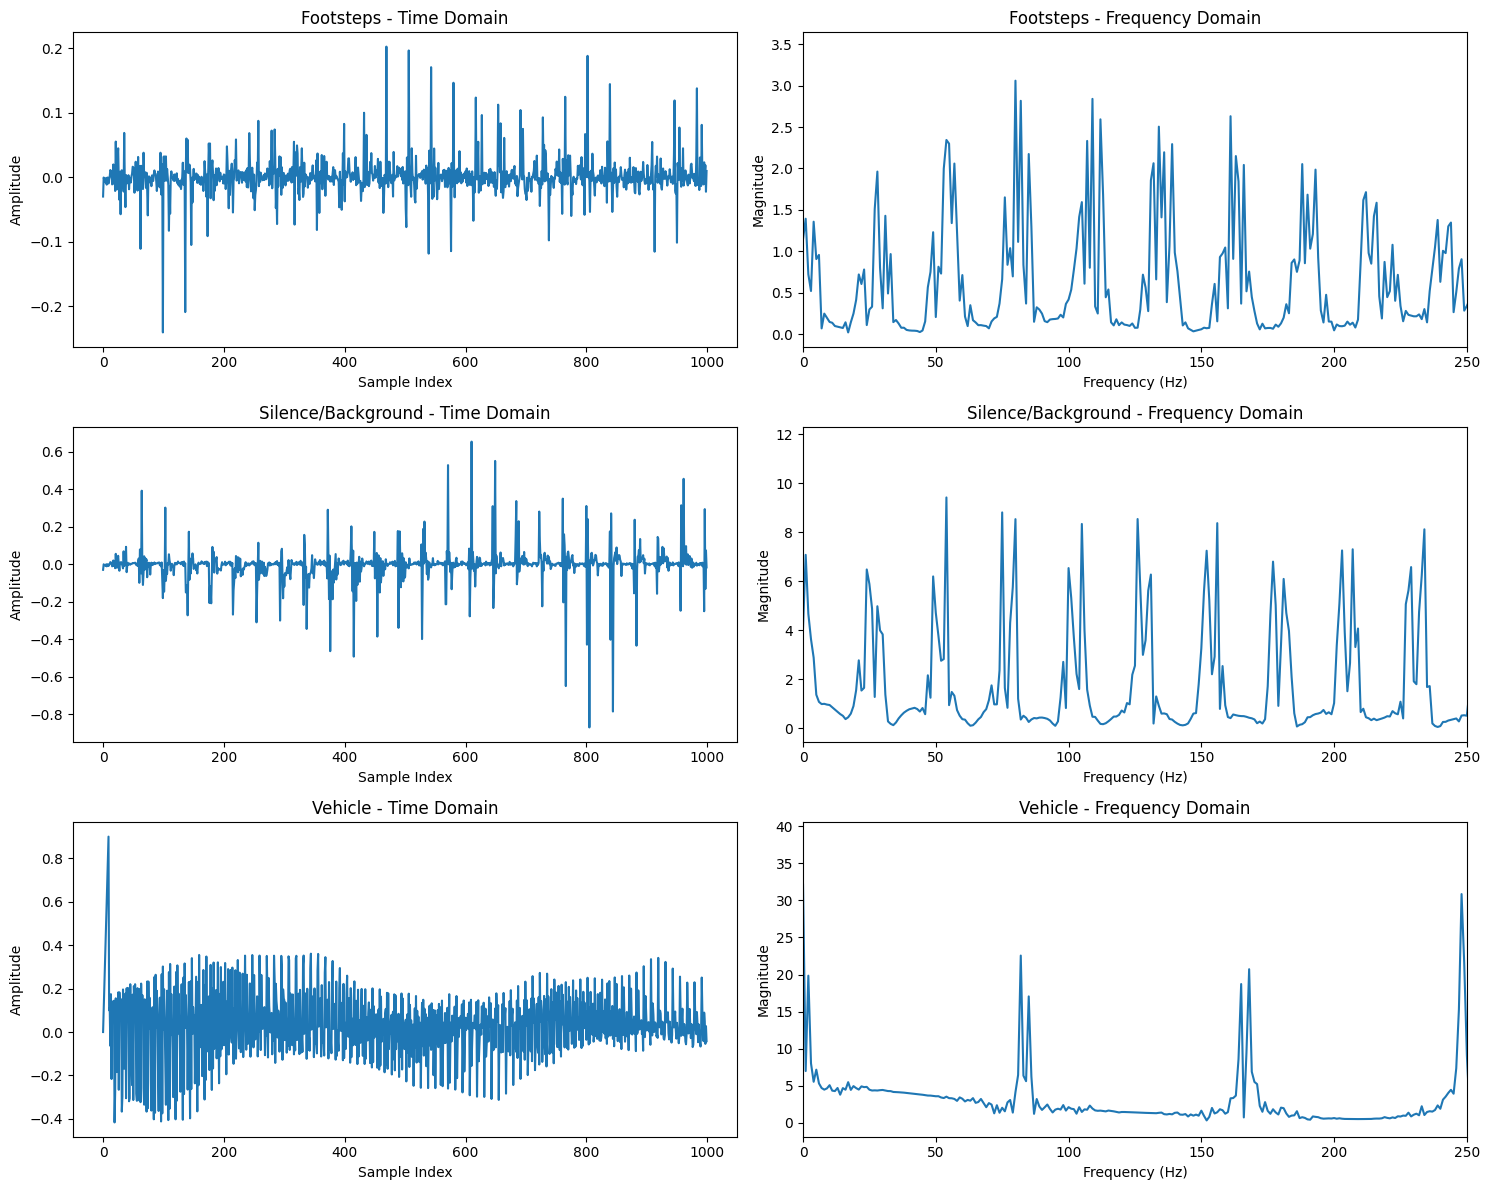

Extracting features...
Feature vector size: 28 features per segment
Checking feature integrity...


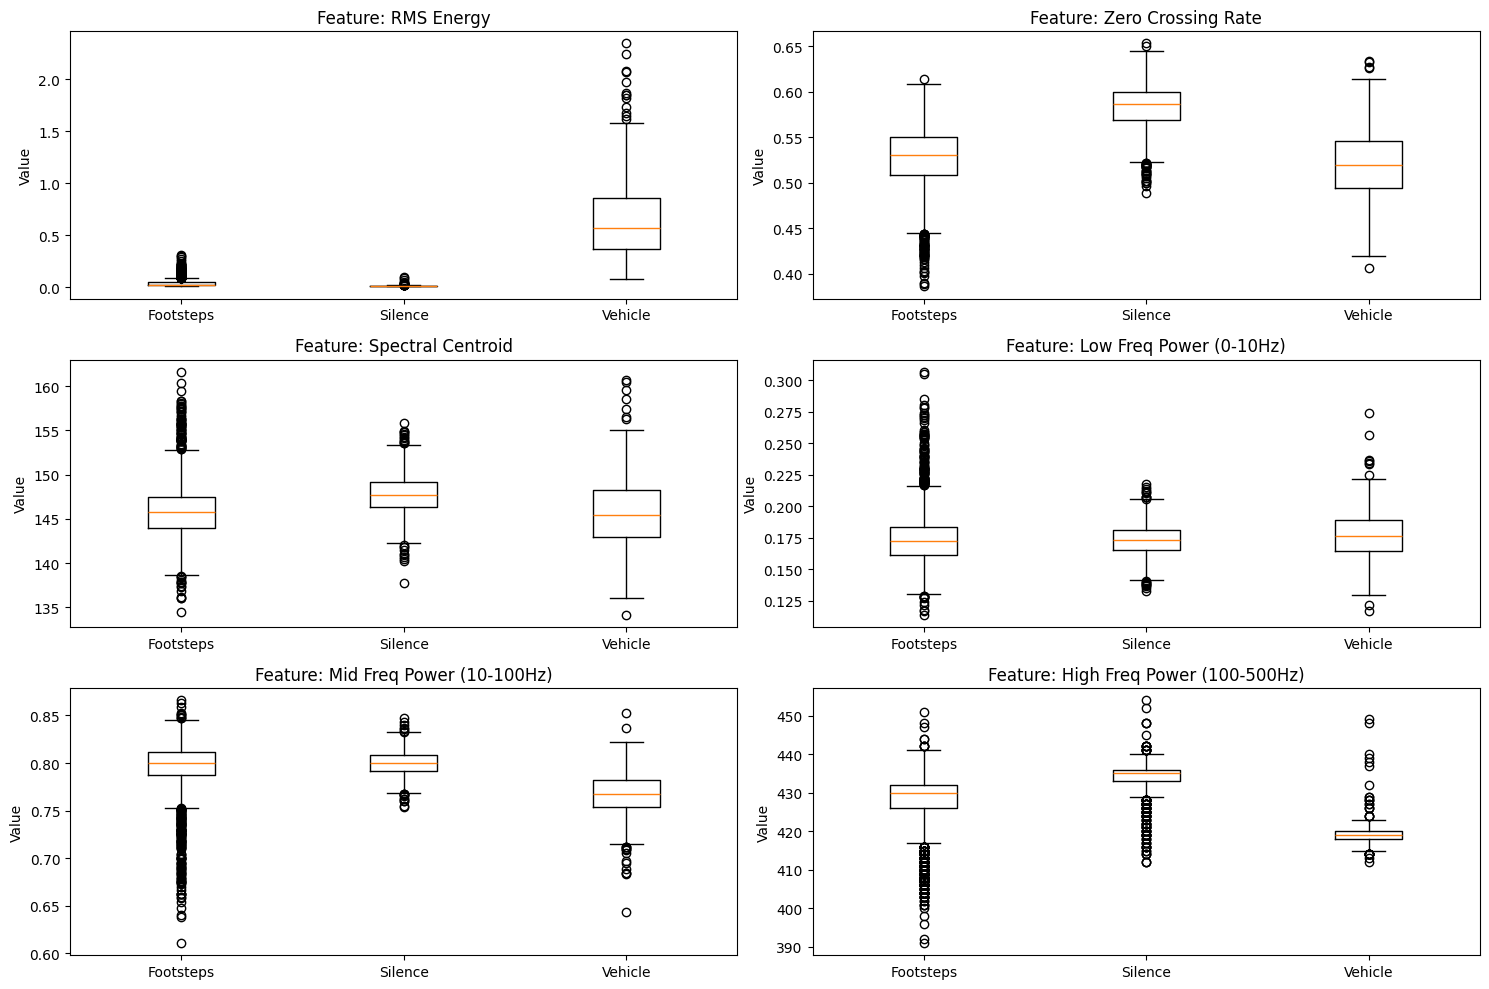

Preparing training data...
Training set: torch.Size([3957, 28])
Test set: torch.Size([990, 28])
Creating CNN model with input size 28...
SpectralCNN(
  (conv_layers): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.2, inplace=False)
    (10): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool1d(kernel_size=2, stride=2, padd

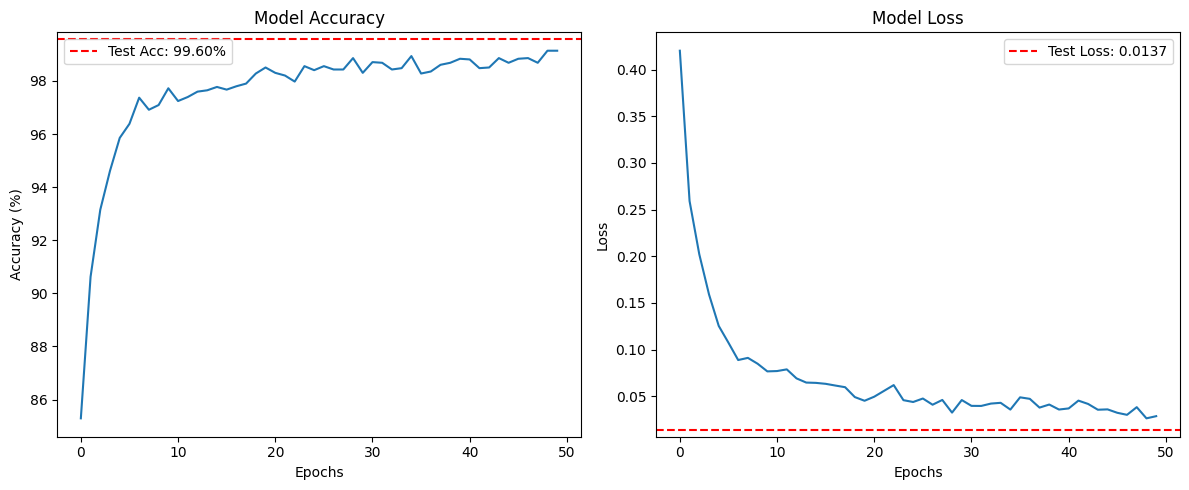

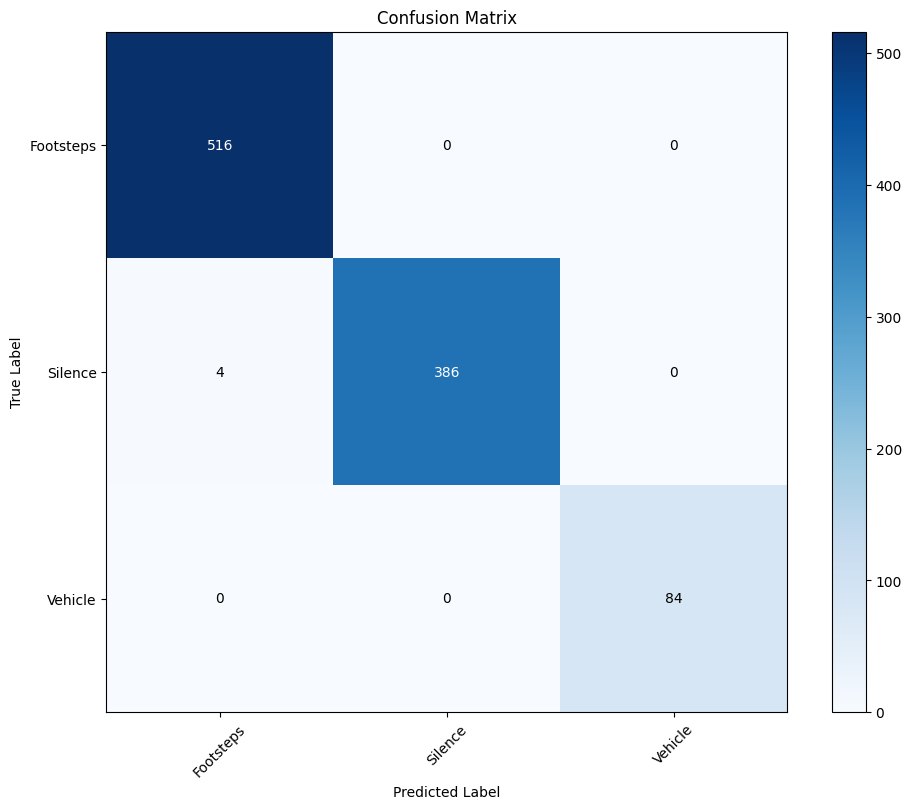


Classification Report:
              precision    recall  f1-score   support

   Footsteps       0.99      1.00      1.00       516
     Silence       1.00      0.99      0.99       390
     Vehicle       1.00      1.00      1.00        84

    accuracy                           1.00       990
   macro avg       1.00      1.00      1.00       990
weighted avg       1.00      1.00      1.00       990

Model saved as geophone_classifier_cnn.pth
Scaler saved as geophone_scaler.pkl


In [8]:

# Step 5: Training and Evaluation
def train_model(model, train_loader, optimizer, criterion, device, epochs=50):
    model.train()
    train_losses = []
    train_accs = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.0 * correct / total
        
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accs

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    
    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    test_loss = test_loss / len(test_loader)
    test_acc = 100.0 * correct / total
    
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')
    
    return test_loss, test_acc, np.array(all_preds), np.array(all_labels)

def visualize_training_results(train_losses, train_accs, test_loss, test_acc):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_accs)
    plt.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Acc: {test_acc:.2f}%')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_losses)
    plt.axhline(y=test_loss, color='r', linestyle='--', label=f'Test Loss: {test_loss:.4f}')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def visualize_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    tick_marks = np.arange(len(CLASS_NAMES))
    plt.xticks(tick_marks, CLASS_NAMES, rotation=45)
    plt.yticks(tick_marks, CLASS_NAMES)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

# Main execution function
def train_geophone_classifier(footsteps_path, silence_path, vehicle_path, model_type='cnn'):
    # Load and visualize data
    footsteps_data, silence_data, vehicle_data = load_data(footsteps_path, silence_path, vehicle_path)
    visualize_signals(footsteps_data, silence_data, vehicle_data)
    
    # Segment signals
    print("Segmenting signals with window size:", WINDOW_SIZE, "and hop length:", HOP_LENGTH)
    footsteps_segments = segment_signal(footsteps_data)
    silence_segments = segment_signal(silence_data)
    vehicle_segments = segment_signal(vehicle_data)
    
    print(f"Footsteps segments: {len(footsteps_segments)}")
    print(f"Silence segments: {len(silence_segments)}")
    print(f"Vehicle segments: {len(vehicle_segments)}")
    
    # Visualize spectral content
    print("Generating spectral content visualizations...")
    visualize_spectral_content(footsteps_segments, silence_segments, vehicle_segments)
    
    # Extract features
    print("Extracting features...")
    footsteps_features = np.array([extract_features(segment) for segment in footsteps_segments])
    silence_features = np.array([extract_features(segment) for segment in silence_segments])
    vehicle_features = np.array([extract_features(segment) for segment in vehicle_segments])
    
    print(f"Feature vector size: {footsteps_features.shape[1]} features per segment")
    
    # Check for NaN values in features
    print("Checking feature integrity...")
    footsteps_features = np.nan_to_num(footsteps_features)
    silence_features = np.nan_to_num(silence_features)
    vehicle_features = np.nan_to_num(vehicle_features)
    
    # Visualize features
    visualize_feature_comparison(footsteps_features, silence_features, vehicle_features)
    
    # Prepare data for training
    print("Preparing training data...")
    
    # Create labels
    footsteps_labels = np.zeros(len(footsteps_features))
    silence_labels = np.ones(len(silence_features))
    vehicle_labels = np.ones(len(vehicle_features)) * 2
    
    # Combine data
    X = np.vstack([footsteps_features, silence_features, vehicle_features])
    y = np.concatenate([footsteps_labels, silence_labels, vehicle_labels])
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Check for NaN/Inf values after scaling
    X_scaled = np.nan_to_num(X_scaled)
    
    # Split into train and test sets
    X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
    
    # Convert to PyTorch tensors
    X_train = torch.FloatTensor(X_train_np)
    X_test = torch.FloatTensor(X_test_np)
    y_train = torch.LongTensor(y_train_np.astype(int))
    y_test = torch.LongTensor(y_test_np.astype(int))
    
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    
    # Create data loaders
    batch_size = 32
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)
    
    # Initialize model
    input_size = X_train.shape[1]
    print(f"Creating {model_type.upper()} model with input size {input_size}...")
    
    if model_type.lower() == 'cnn':
        model = SpectralCNN(input_size, NUM_CLASSES)
    elif model_type.lower() == 'lstm':
        model = SpectralLSTM(input_size, NUM_CLASSES)
    else:
        raise ValueError("Model type not supported. Choose 'cnn' or 'lstm'")
    
    model = model.to(device)
    print(model)
    
    # Train model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    print("Training model...")
    epochs = 50
    train_losses, train_accs = train_model(model, train_loader, optimizer, criterion, device, epochs)
    
    # Evaluate model
    print("Evaluating model...")
    test_loss, test_acc, y_pred, y_true = evaluate_model(model, test_loader, criterion, device)
    
    # Visualize results
    visualize_training_results(train_losses, train_accs, test_loss, test_acc)
    visualize_confusion_matrix(y_true, y_pred)
    
    # Save model and scaler
    model_filename = f"geophone_classifier_{model_type}.pth"
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'model_type': model_type,
        'input_size': input_size,
        'num_classes': NUM_CLASSES,
        'feature_vector_size': footsteps_features.shape[1]
    }, model_filename)
    
    import joblib
    joblib.dump(scaler, 'geophone_scaler.pkl')
    
    print(f"Model saved as {model_filename}")
    print(f"Scaler saved as geophone_scaler.pkl")
    
    return model, scaler

# Code for prediction
def predict_signal(signal_path, model_path, scaler_path):
    # Load model
    checkpoint = torch.load(model_path, map_location=device)
    model_type = checkpoint['model_type']
    input_size = checkpoint['input_size']
    
    if model_type.lower() == 'cnn':
        model = SpectralCNN(input_size, NUM_CLASSES)
    elif model_type.lower() == 'lstm':
        model = SpectralLSTM(input_size, NUM_CLASSES)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()
    
    # Load scaler
    import joblib
    scaler = joblib.load(scaler_path)
    
    # Load signal
    signal_data = pd.read_csv(signal_path, header=None).values.flatten()
    
    # Ensure no NaN/Inf values
    signal_data = np.nan_to_num(signal_data)
    
    # Segment signal
    segments = segment_signal(signal_data)
    
    if len(segments) == 0:
        print("Signal too short for analysis")
        return None
    
    # Extract features
    features = np.array([extract_features(segment) for segment in segments])
    
    # Ensure no NaN/Inf values in features
    features = np.nan_to_num(features)
    
    # Normalize features
    features_scaled = scaler.transform(features)
    features_scaled = np.nan_to_num(features_scaled)
    
    # Convert to tensor
    features_tensor = torch.FloatTensor(features_scaled).to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(features_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        _, predictions = torch.max(probabilities, 1)
        predictions = predictions.cpu().numpy()
    
    # Count predictions
    unique, counts = np.unique(predictions, return_counts=True)
    pred_counts = dict(zip(unique, counts))
    
    # Get dominant class
    if pred_counts:
        dominant_class = max(pred_counts, key=pred_counts.get)
        confidence = pred_counts[dominant_class] / len(predictions) * 100
    else:
        dominant_class = -1
        confidence = 0
    
    # Visualize
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(signal_data)
    plt.title(f'Signal Classification: {CLASS_NAMES[dominant_class] if dominant_class >= 0 else "Unknown"}')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    
    plt.subplot(2, 1, 2)
    counts_list = [pred_counts.get(idx, 0) for idx in range(NUM_CLASSES)]
    plt.bar(CLASS_NAMES, counts_list)
    plt.title(f'Prediction Distribution (Dominant: {CLASS_NAMES[dominant_class] if dominant_class >= 0 else "Unknown"}, Confidence: {confidence:.1f}%)')
    plt.ylabel('Segment Count')
    
    plt.tight_layout()
    plt.savefig('prediction_result.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"Predicted class: {CLASS_NAMES[dominant_class] if dominant_class >= 0 else 'Unknown'}")
    print(f"Confidence: {confidence:.1f}%")
    
    return {
        'class': CLASS_NAMES[dominant_class] if dominant_class >= 0 else "Unknown",
        'confidence': confidence,
        'distribution': pred_counts,
        'predictions': predictions
    }

# Example usage
if __name__ == "__main__":
    # File paths
    footsteps_path = "man.csv"
    silence_path = "nothing.csv"
    vehicle_path = "car.csv"
    
    # Choose model type: 'cnn' or 'lstm'
    model_type = 'cnn'
    
    # Train or load model
    train_new_model = True
    
    if train_new_model:
        model, scaler = train_geophone_classifier(footsteps_path, silence_path, vehicle_path, model_type)
    else:
        # For prediction only
        signal_to_predict = "unknown_signal.csv"
        model_path = f"geophone_classifier_{model_type}.pth"
        scaler_path = "geophone_scaler.pkl"
        
        result = predict_signal(signal_to_predict, model_path, scaler_path)